In [8]:
import frame
from classifier_tf import DataLoader
import pong_catastrophe

episode_paths = frame.episode_paths('PongDeterministic-v3-Episodes/')
penalty_episode_paths = frame.episode_paths('pong_frames_penalty/')

def get_episodes(episode_paths):
    episodes = []
    for path in episode_paths:
        episodes.append(frame.load_episode(path))
    return episodes

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
    
np.random.seed(seed=42)
np.random.shuffle(episode_paths)
np.random.shuffle(penalty_episode_paths)
#data_loader = DataLoader(pong_catastrophe.PongClassifierLabeller())
#dataset_paths = data_loader.split_episodes(episode_paths, 1, 1, 1)
#datasets = [get_episodes(paths) for paths in dataset_paths]

In [9]:
number_episodes = 22
number_penalty_episodes = 30
use_process_ENVS = False
RESIZE_DIM = (42,42)

TEST_SET_SPLIT = 0.5

RESIZE_ON = True
IMAGE_LENGTH = RESIZE_DIM[0] * RESIZE_DIM[1]

In [10]:
def gather_frames(all_episodes):
    all_frames = []
    for episode in all_episodes:
        for frame in episode.frames:
            all_frames.append(frame)
    return all_frames

def gather_labels(episodes):    
    labeller = pong_catastrophe.PongClassifierLabeller()
    all_labels = []
    for episode in episodes:
        _, labels = labeller.label([], episode)
        all_labels += list(labels)
    return all_labels

def bool_to_one_hot(bool):
    return np.array([1., 0.]) if bool else np.array([0., 1.])

def from_one_hot(Y):
    new_Y = []
    for row in Y:
        new_row = 1. if row[0]==1. else 0.
        new_Y.append(new_row)
    return np.array(new_Y)

def show_random_labeled_examples(ims, k=4):
    xs = ims
    for _ in range(k):
        j = np.random.randint(len(xs))
        im = xs[j]
        if len(im.shape) < 2:
            plt.imshow(np.reshape(im,RESIZE_DIM))
            plt.show()
        else:
            plt.imshow(im)
            plt.show()
            
def show_random_labeled_examples_GYM(ims, k=4):
    xs = ims
    for _ in range(k):
        j = np.random.randint(len(xs))
        im = xs[j]
        if len(im.shape) < 2:
            plt.imshow(np.reshape(im,(42,42)))
            plt.show()
        else:
            plt.imshow(im)
            plt.show()
        #print( ys[j])    

def show_im(im):
    plt.imshow(im, cmap='gray')
    plt.show()
       
def preprocess(im):  
    im2 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)    
    im3 = im2[31:195,:]
    resize = cv2.resize(im3, RESIZE_DIM, interpolation = cv2.INTER_AREA) 
    return resize if RESIZE_ON else im3

def preprocess_from_ENVS(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    
    frame = frame[34:194,:160]
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, RESIZE_DIM)
    #frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    return frame

def subtract_mean(image_label):
    d = 1600  #CHANGE
    means = np.mean(image_label, axis=0)
    means[d:] = 0.
    minus_mean = image_label - means
    return minus_mean 
    
def frames_to_processed_images(frames):
    image_list = []
    for f in frames:
        im = preprocess_from_ENVS(f.image) if use_process_ENVS else preprocess(f.image)
        im_flat = np.array(im, dtype='float32').reshape(-1)
        #im_norm = im_flat / im_flat.sum()   # normalize
        image_list.append(im_flat)
    
    return image_list #image_ar = subtract_mean(image_ar)  
  
def split_image_label(image_label_matrix, IMAGE_LENGTH):
    return [ image_label_matrix[:,:IMAGE_LENGTH], image_label_matrix[:,IMAGE_LENGTH:] ]

def get_batches(data_image_label, batch_size):
    rows = data_image_label.shape[0]
    num_batches = np.floor(rows / batch_size)
    return np.vsplit(data_image_label[:int(num_batches*batch_size),:], num_batches)
    

def get_shuffled_data_subset(data_image_label, batch_size, subset_size):
    n = data_image_label.shape[0]
    subset_size = n if subset_size > n else subset_size
        
    copy_image_label_all = np.copy(data_image_label)
    copy_image_label = copy_image_label_all[:subset_size,:]
    np.random.shuffle(copy_image_label)
    batches =  get_batches(copy_image_label, batch_size)
    return [split_image_label(batch,IMAGE_LENGTH) for batch in batches]


def episodes_to_data(episodes, test_training_split=True):
    frames = gather_frames(episodes)
    labels = gather_labels(episodes)
    labels = [bool_to_one_hot(label) for label in labels]
    
    processed_images = np.array(frames_to_processed_images(frames))
    labels_ar = np.array(labels, ndmin=2)
    data_image_label = np.concatenate((processed_images,labels_ar),axis=1)

    if not(test_training_split):
        return split_image_label(data_image_label,IMAGE_LENGTH)
    else:
        n = np.int(len(frames)*TEST_SET_SPLIT)
        training_data_image_label = data_image_label[:n,:]
        training_data = split_image_label(training_data_image_label,IMAGE_LENGTH)
        
        test_data_image_label = data_image_label[n:,:]
        test_data = split_image_label(test_data_image_label,IMAGE_LENGTH)
    
        BATCH_SIZE = 50
        get_next_pass_subset = lambda n:get_shuffled_data_subset(training_data_image_label, BATCH_SIZE, n)
   
        return dict(data_image_label=data_image_label,
                    training_data=training_data,
                    test_data=test_data,
                    get_next_pass_subset=get_next_pass_subset)

import time
start_time = time.time()
episodes = get_episodes(episode_paths[:number_episodes])
out = episodes_to_data(episodes)
training_data = out['training_data']
training_data_image_label = out['data_image_label']
test_data = out['test_data']
get_next_pass_subset = out['get_next_pass_subset']    

penalty_episodes = get_episodes(episode_paths[:number_penalty_episodes])
penalty_test_data = episodes_to_data(penalty_episodes,test_training_split=False)
X_penalty, Y_penalty = penalty_test_data
print('n = ', training_data[0].shape[0], 'load time=', time.time() - start_time)

n =  16558 load time= 94.27815699577332


In [11]:
import classifier_utils

X_train, Y_train = training_data
Y_train = from_one_hot(Y_train)
X_test, Y_test = test_data
Y_test = from_one_hot(Y_test)
Y_penalty_RF = from_one_hot(Y_penalty)

classifier_utils.run_predict_logistic_regression(X_train,Y_train,X_test,Y_test)
classifier_utils.run_predict_random_forest(X_train,Y_train,X_test,Y_test, 
                                           n_estimators=20, max_features=600, show_mistakes=False)
print('\n\n RF generalize:')
classifier_utils.run_predict_random_forest(X_train,Y_train,X_penalty,Y_penalty_RF, 
                                           n_estimators=20, max_features=600, show_mistakes=False)

Logistic 0-1 error. 
 Training:  0.0 
 Test: 0.0

 Random forest 0-1 error.  
 Train:  0.00658292064259 
 Test:  0.00603901201763
Metrics: {'fpr': 0.00017051752067524938, 'np.std(y_pred)': 0.2565684008061781, 'recall': 1.0, 'threshold': 0.41599134527019394, 'precision': 0.9995860927152318, 'loss': 0.22554831996265187, 'auc': 0.99999989408849654}


 RF generalize:

 Random forest 0-1 error.  
 Train:  0.00018118130209 
 Test:  0.000276196141752
Metrics: {'fpr': 0.0, 'np.std(y_pred)': 0.31981753279940145, 'recall': 1.0, 'threshold': 0.43739310850415525, 'precision': 1.0, 'loss': 0.15215955603367029, 'auc': 1.0}


In [12]:
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score

class ScoreNN(object):
    
    def __init__(self):
        pass

    def threshold_from_data(self, X, y, y_pred):
        y_bool = y.reshape(-1) == 1.   ## true if x is a catast
        if np.count_nonzero(y) == 0:
            return np.max(y_pred)
        probs_of_catastrophe = y_pred[y_bool][:,0]
        return np.min(probs_of_catastrophe) # TODO CHANGED FROM WILL CODE

    def metrics(self, X, y, y_pred_pair):
        metrics = {}
        y_pred = y_pred_pair[:,0]  ## From softmax pair to prob of catastrophe
        
        #metrics['loss'] = loss
        threshold = self.threshold_from_data(X, y, y_pred_pair)
        metrics['threshold'] = threshold
        metrics['np.std(y_pred)'] = np.std(y_pred)
        denom = np.count_nonzero(y == False)
        num = np.count_nonzero(np.logical_and(y.reshape(-1) == False, y_pred >= threshold))
        
        metrics['fpr'] = float(num) / float(denom)
        if any(y) and not all(y):
            metrics['auc'] = roc_auc_score(y, y_pred)
            y_pred_bool = y_pred >= threshold
            if (any(y_pred_bool) and not all(y_pred_bool)):
                metrics['precision'] = precision_score(np.array(y, dtype=np.float32), y_pred_bool)
                metrics['recall'] = recall_score(y, y_pred_bool)

        return metrics
    
    def metrics_generalize(self, X, y, y_pred_pair, test_threshold):
        metrics = {}
        y_pred = y_pred_pair[:,0]  ## From softmax pair to prob of catastrophe
        threshold = test_threshold
        metrics['threshold'] = threshold
        metrics['np.std(y_pred)'] = np.std(y_pred)
        denom = np.count_nonzero(y == False)
        num = np.count_nonzero(np.logical_and(y.reshape(-1) == False, y_pred >= threshold))
        
        metrics['fpr'] = float(num) / float(denom)
        if any(y) and not all(y):
            metrics['auc'] = roc_auc_score(y, y_pred)
            y_pred_bool = y_pred >= threshold
            if (any(y_pred_bool) and not all(y_pred_bool)):
                metrics['precision'] = precision_score(np.array(y, dtype=np.float32), y_pred_bool)
                metrics['recall'] = recall_score(y, y_pred_bool)

        return metrics

    def softmax_y(self, y_score):
        return np.exp(y_score) / np.sum(np.exp(y_score), axis=1).reshape(-1,1)

    def get_gaps(self, y, y_pred):  ## y pred is nx2 softmax predictions
        return np.abs(y[:,0] - y_pred[:,0])

    def show_mistakes(self, X, y, y_pred,k):
        gaps = self.get_gaps(y,y_pred)
        index_gap = np.array([[i,gap] for i,gap in enumerate(gaps)])
        sorted_index_gap = index_gap[index_gap[:,1].argsort()]
        tail_index_gap = sorted_index_gap[-k:,:]

        xs = []
        probs = []
        for row in range(k):
            index,gap = tail_index_gap[row,:]
            x = X[int(index),:]
            xs.append(x)
            show_im(x.reshape(RESIZE_DIM[0],RESIZE_DIM[1]))
            print('Is catastr:', y[int(index)] == 1., '. Prob gap: ', gap, ' \n ')    
        return xs
    
scoreNN = ScoreNN()   
    
import tensorflow as tf

def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summary'+name):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def add_noise_to_training(training_data_matrix, false_positive_rate, false_negative_rate):
    """Labels are bools"""
    images, labels1 = split_image_label(training_data_matrix, IMAGE_LENGTH)
    labels2 = from_one_hot(labels1)
    labels = labels2 == 1.
    if false_positive_rate > 0 or false_negative_rate > 0:
        r = np.random.RandomState()
        p = r.rand(len(labels))
        original_labels = np.copy(labels)
        labels[(~original_labels) & (p < false_positive_rate)] = True
        labels[(original_labels) & (p < false_negative_rate)] = False
        
    
    labels_ar = np.array([bool_to_one_hot(label) for label in labels], ndmin=2)
    training_data_matrix_noisified = np.concatenate((images,labels_ar),axis=1)
    return training_data_matrix_noisified


--------------
Training set n= 10000 . Frames*passes =  40000
Test set n= 16559 . Generalize n= 47068
Base rate for positive instance in test set: 0.291684280452
step (num batches) 0, accuracy on minibatch 0.48
step (num batches) 300, accuracy on minibatch 0.9
step (num batches) 600, accuracy on minibatch 0.96


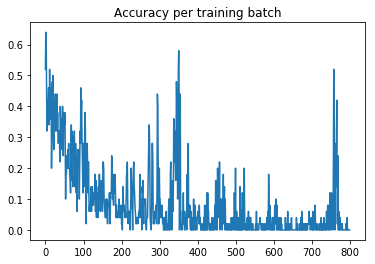


 Test accuracy:  0.998369

 METRICS:  {'fpr': 0.006650183306334726, 'np.std(y_pred)': 0.45361656, 'recall': 1.0, 'threshold': 0.0015692106, 'precision': 0.9841075794621027, 'auc': 0.99998534890867907}

 -------  
GENERALIZE ACCURACY

 Generalize batches:

 Test accuracy:  0.99847

 METRICS:  {'fpr': 0.0037652557777200727, 'np.std(y_pred)': 0.47470042, 'recall': 1.0, 'threshold': 0.0015692106, 'precision': 0.99291646311675619, 'auc': 0.99998393414211995}

 Test accuracy:  0.99847

 METRICS:  {'fpr': 0.008284432171211598, 'np.std(y_pred)': 0.43865299, 'recall': 1.0, 'threshold': 0.0015692106, 'precision': 0.97712833545108002, 'auc': 0.99998271832257302}

 Test accuracy:  0.997705

 METRICS:  {'fpr': 0.005598229397213905, 'np.std(y_pred)': 0.47492921, 'recall': 1.0, 'threshold': 0.0015692106, 'precision': 0.98958585613950112, 'auc': 0.99998212497187311}

 Test accuracy:  0.997111

 METRICS:  {'fpr': 0.010647107535786111, 'np.std(y_pred)': 0.44947112, 'recall': 1.0, 'threshold': 0.0015692

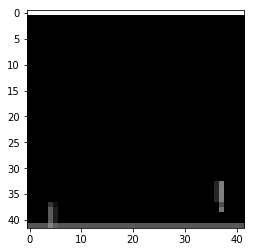

Is catastr: [False] . Prob gap:  0.999999880791  
 


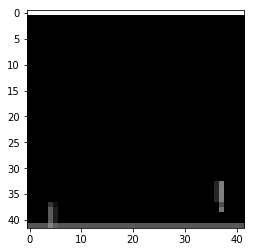

Is catastr: [False] . Prob gap:  0.999999880791  
 


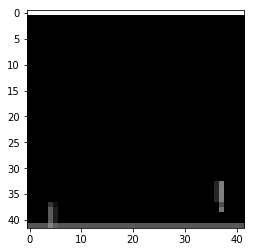

Is catastr: [False] . Prob gap:  0.999999880791  
 
All Metrics: {'fpr': 0.0071940234266916715, 'np.std(y_pred)': 0.46124575, 'recall': 1.0, 'threshold': 0.0015692106, 'precision': 0.98416243654822333, 'auc': 0.99995679053781583}


In [14]:
log_dir = "/tmp/tf"


def run_model(training_data_matrix, number_frames, number_passes = 1):
    tf.reset_default_graph()
    sess = tf.InteractiveSession()

    num_filters1 = 4
    num_filters2 = 4
    len_fc = 50
    
    num_filters1 = 10
    num_filters2 = 10
    len_fc = 100

    # inputs
    d = RESIZE_DIM[0] * RESIZE_DIM[1]
    number_classes = 2
    x = tf.placeholder(tf.float32, shape=[None, d])
    y_ = tf.placeholder(tf.float32, shape=[None, number_classes])
    y_binary = tf.placeholder(tf.float32, shape=[None,1])

    x_dim = RESIZE_DIM
    with tf.name_scope('input_reshape'):
        x_image = tf.reshape(x, [-1, x_dim[0], x_dim[1],1])
        tf.summary.image('input',x_image, 15)

    #layer 1
    W_conv1 = weight_variable([5, 5, 1, num_filters1])
    b_conv1 = bias_variable([num_filters1])
    variable_summaries(W_conv1, 'W_conv1')
    variable_summaries(b_conv1, 'b_conv1')

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) ## output 40x40x3
    #h_pool1 = max_pool_2x2(h_conv1)   # output is 20x20x32

    W_image = tf.reshape(W_conv1, [num_filters1, 5, 5, 1])
    tf.summary.image('W_conv1', W_image, num_filters1)
    variable_summaries(h_conv1, 'h_conv1')
    x_dim1 = RESIZE_DIM

    # layer 2
    W_conv2 = weight_variable([5, 5, num_filters1, num_filters2])
    b_conv2 = bias_variable([num_filters2])

    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
    x_dim2 = RESIZE_DIM


    # FC layer 1   ## 1600* 4 = 6400
    W_fc1 = weight_variable([x_dim2[0] * x_dim2[1] * num_filters2, len_fc])
    b_fc1 = bias_variable([len_fc])
    variable_summaries(W_fc1, 'W_fc1')

    h_conv2_flat = tf.reshape(h_conv2, [-1, x_dim2[0] * x_dim2[1] * num_filters2])
    h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

    ## FC layer 2
    W_fc2 = weight_variable([len_fc, number_classes])
    b_fc2 = bias_variable([number_classes])

    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

    #losses = y_binary - y_conv[:,1]

    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    accuracy_graph = []

    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir, sess.graph)



    ## TRAIN
    sess.run(tf.global_variables_initializer())
    batch_size = 50
    X_test,Y_test = test_data

    print('\n--------------\nTraining set n=', number_frames, '. Frames*passes = ', number_frames*number_passes)
    print('Test set n=', X_test.shape[0], '. Generalize n=', X_penalty.shape[0])
    print('Base rate for positive instance in test set:', np.mean(Y_test[:,0]))

    step = 0
    for _ in range(number_passes):
        single_pass = get_shuffled_data_subset(training_data_matrix, batch_size, number_frames)
        
        for batch in single_pass:
            xs, ys = batch
            train_accuracy = accuracy.eval(feed_dict={x: xs, y_: ys})    
            accuracy_graph.append(1.-train_accuracy)

            if step % 300 == 0:
                print("step (num batches) %d, accuracy on minibatch %g"%(step, train_accuracy))

            summary, _ = sess.run([merged, train_step], feed_dict= {x:xs, y_:ys})

            train_writer.add_summary(summary, step)

            train_step.run(feed_dict={x: xs, y_: ys})
            step += 1

    train_writer.close()
    saver = tf.train.Saver()
    save_path = saver.save(sess, "/tmp/tf/model.ckpt") #saver.restore(sess, "/tmp/tf/model.ckpt")
    #print("Model saved in file: %s" % save_path)
    
    plt.plot(accuracy_graph)
    plt.title('Accuracy per training batch')
    plt.show()
    
    def test_performance(X_test,Y_test,mistakes=False, generalize=False, test_threshold=None):
        accuracy_test, y_conv_test = sess.run([accuracy, y_conv], feed_dict={x: X_test, y_: Y_test})
        print("\n Test accuracy: ", accuracy_test)
    
        y_pred = scoreNN.softmax_y(y_conv_test)
        Y_convert = from_one_hot(Y_test)
        Y_binary = Y_convert.reshape(len(Y_convert),1)
        
        if mistakes:
            scoreNN.show_mistakes(X_test,Y_binary,y_pred,3)
        if generalize:
            metrics = scoreNN.metrics_generalize(X_test,Y_binary,y_pred, test_threshold)
        else:
            metrics = scoreNN.metrics(X_test,Y_binary,y_pred)
        print('\n METRICS: ',metrics)
        return y_pred, metrics['threshold']
    
    
    _, test_threshold = test_performance(X_test,Y_test, False)
    
    

    
    print('\n -------  \nGENERALIZE ACCURACY')
    def run_generalize():
        batch_size = 10000
        num_batches = max(1,np.floor(X_penalty.shape[0] / batch_size))
        batches_X = np.array_split(X_penalty, num_batches, axis=0)
        batches_Y = np.array_split(Y_penalty, num_batches, axis=0)

        generalize_y_pred_list = []
        print('\n Generalize batches:')
        for xs,ys in zip(batches_X, batches_Y):
            generalize_y_pred, _ = test_performance(xs,ys, generalize=True, test_threshold=test_threshold)
            generalize_y_pred_list.append(generalize_y_pred)
        
        all_y_pred = np.concatenate(generalize_y_pred_list,axis=0)
        Y_convert = from_one_hot(Y_penalty)
        Y_binary = Y_convert.reshape(len(Y_convert),1)
        print('\n\n All mistakes: ')
        scoreNN.show_mistakes(X_penalty,Y_binary,all_y_pred,3)
        print('All Metrics:', scoreNN.metrics_generalize(X_penalty, Y_binary, all_y_pred, test_threshold))
        return all_y_pred
    
    all_y_pred = run_generalize()
    sess.close()
    return all_y_pred
    
    
false_positive_rate = .0001
false_negative_rate = .0001
training_data_matrix = add_noise_to_training(training_data_image_label, false_positive_rate, false_negative_rate)
number_frames = 10000


number_passes = 4
ensemble_size = 1
run_model_thunk = lambda: run_model(training_data_matrix, number_frames, number_passes)
y_pred_list = [run_model_thunk() for _ in range(ensemble_size)]


Next y_pred: {'fpr': 0.5513432835820895, 'threshold': 0.0098929405, 'np.std(y_pred)': 0.40068018, 'recall': 1.0, 'auc': 0.99366707418538702, 'precision': 0.45830481963046243}

Next y_pred: {'fpr': 0.1389054726368159, 'threshold': 0.13321622, 'np.std(y_pred)': 0.41127157, 'recall': 1.0, 'auc': 0.99687645390793478, 'precision': 0.77054569362261671}


 y_pred_mean: {'fpr': 0.10288557213930348, 'threshold': 0.20652598, 'np.std(y_pred)': 0.3979249, 'recall': 1.0, 'auc': 0.99879266211604101, 'precision': 0.81929395316322962}


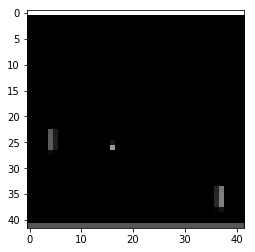

Is catastr: [ True] . Prob gap:  0.793474018574  
 


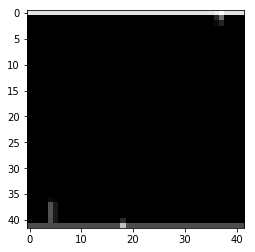

Is catastr: [False] . Prob gap:  0.838322639465  
 


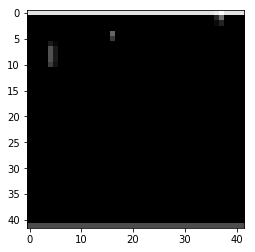

Is catastr: [False] . Prob gap:  0.917683005333  
 


In [34]:
### need to rewrite. 
def run_ensemble(y_pred_list):
    y_pred_mean = sum(y_pred_list) / len(y_pred_list)
    scoreNN = ScoreNN()
    Y_convert = from_one_hot(Y_penalty)
    Y_binary = Y_convert.reshape(len(Y_convert),1)

    for y_pred in y_pred_list:
        metrics = scoreNN.metrics(X_penalty,Y_binary,y_pred)
        print('\nNext y_pred:',metrics)

    metrics = scoreNN.metrics(X_test,Y_binary,y_pred_mean)
    print('\n\n y_pred_mean:',metrics)
    scoreNN.show_mistakes(X_penalty,Y_binary,y_pred_mean,3)

run_ensemble(y_pred_list)

step (num batches) 0, training accuracy 0.7
step (num batches) 1000, training accuracy 0.94
Base rate for positive instance: 0.500248138958
test accuracy 0.972953


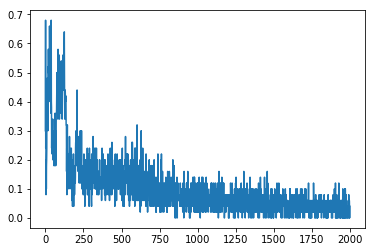

In [5]:
## MLP VERSION
d = 1600
number_classes = 2
x = tf.placeholder(tf.float32, shape=[None, d])
y_ = tf.placeholder(tf.float32, shape=[None, number_classes])
x_dim = [40,40]

with tf.name_scope('input_reshape'):
    x_image = tf.reshape(x, [-1, x_dim[0], x_dim[1],1])
    tf.summary.image('input',x_image,15)
    

# FC layer 1
len_fc1 = 200
W_fc1 = weight_variable([d, len_fc1])
b_fc1 = bias_variable([len_fc1])
tf.summary.scalar('W1_mean', tf.reduce_mean(W_fc1))
tf.summary.scalar('W1_max', tf.reduce_max(W_fc1))
#tf.summary.image('W_fc1', tf.reshape(W_fc1, [1,d,len_fc1,1]) )

h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)
tf.summary.scalar('activation_1_mean', tf.reduce_mean(h_fc1))

# FC layer 2
len_fc2 = 50
W_fc2 = weight_variable([len_fc1, len_fc2])
b_fc2 = bias_variable([len_fc2])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

## FC layer 3
W_fc3 = weight_variable([len_fc2, number_classes])
b_fc3 = bias_variable([number_classes])

y_conv = tf.matmul(h_fc2, W_fc3) + b_fc3

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

lambda_constant = .00001

loss = cross_entropy + lambda_constant * (tf.nn.l2_loss(W_fc1) +
                                          tf.nn.l2_loss(b_fc1) +
                                          tf.nn.l2_loss(W_fc2) +
                                          tf.nn.l2_loss(b_fc2) +
                                          tf.nn.l2_loss(W_fc3))

train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)


correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))


accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))


accuracy_graph = []

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(log_dir, sess.graph)


sess.run(tf.global_variables_initializer())

number_passes = 20
step = 0

for _ in range(number_passes):
    single_pass = get_next_pass()
    for batch in single_pass:
        xs, ys = batch
        train_accuracy = accuracy.eval(feed_dict={x: xs, y_: ys})    
        accuracy_graph.append(1.-train_accuracy)

        if step % 1000 == 0:
            print("step (num batches) %d, training accuracy %g"%(step, train_accuracy))
        
        summary, _ = sess.run([merged, train_step], feed_dict= {x:xs, y_:ys})
        train_writer.add_summary(summary, step)
        step += 1

train_writer.close()
        

X_test,Y_test = test_data
print('Base rate for positive instance:', np.mean(Y_test[:,0]))
print("test accuracy %g"%accuracy.eval(feed_dict={x: X_test, y_: Y_test}))
plt.plot(accuracy_graph)

In [9]:
import os
import numpy as np
#mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

# Data sets
IRIS_TRAINING = "iris_training.csv"
IRIS_TRAINING_URL = "http://download.tensorflow.org/data/iris_training.csv"

IRIS_TEST = "iris_test.csv"
IRIS_TEST_URL = "http://download.tensorflow.org/data/iris_test.csv"


training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
  filename=IRIS_TRAINING,
  target_dtype=np.int,
  features_dtype=np.float32)
test_set = tf.contrib.learn.datasets.base.load_csv_with_header(
  filename=IRIS_TEST,
  target_dtype=np.int,
  features_dtype=np.float32)


In [10]:
from collections import namedtuple

Dataset = namedtuple("Dataset", ["data", "target"])
training_set_copy = Dataset(data=training_set.data, target=training_set.target)

In [8]:
# Specify that all features have real-value data
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=4)]

# Build 3 layer DNN with 10, 20, 10 units respectively.
classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                              hidden_units=[10, 20, 10],
                                              n_classes=3,
                                              model_dir="/tmp/")
# Define the training inputs
def get_train_inputs():
    x = tf.constant(training_set.data)
    y = tf.constant(training_set.target)
    return x, y

# Fit model.
classifier.fit(input_fn=get_train_inputs, steps=2000)

# Define the test inputs
def get_test_inputs():
    x = tf.constant(test_set.data)
    y = tf.constant(test_set.target)
    return x, y

# Evaluate accuracy.
accuracy_score = classifier.evaluate(input_fn=get_test_inputs,
                                   steps=1)["accuracy"]

print("\nTest Accuracy: {0:f}\n".format(accuracy_score))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x114e5bb00>, '_master': '', 'keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_task_id': 0, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'save_checkpoints_steps': None, '_environment': 'local', 'tf_random_seed': None, 'keep_checkpoint_every_n_hours': 10000, 'save_checkpoints_secs': 600, '_is_chief': True, 'save_summary_steps': 100}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_si

InvalidArgumentError: Shape in shape_and_slice spec does not match the shape in the save file: [10,3], save file shape: [10,1]
	 [[Node: save/RestoreV2_16 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_16/tensor_names, save/RestoreV2_16/shape_and_slices)]]

Caused by op 'save/RestoreV2_16', defined at:
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-e070856b00f6>", line 16, in <module>
    classifier.fit(input_fn=get_train_inputs, steps=2000)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/contrib/learn/python/learn/estimators/dnn.py", line 315, in fit
    max_steps=max_steps)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 191, in new_func
    return func(*args, **kwargs)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/contrib/learn/python/learn/estimators/estimator.py", line 355, in fit
    max_steps=max_steps)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/contrib/learn/python/learn/estimators/estimator.py", line 733, in _train_model
    max_steps=max_steps)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/contrib/learn/python/learn/graph_actions.py", line 297, in _monitored_train
    hooks=all_hooks) as super_sess:
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 447, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 618, in __init__
    _WrappedSession.__init__(self, self._sess_creator.create_session())
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 505, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 333, in create_session
    self._scaffold.finalize()
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 163, in finalize
    self._saver.build()
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 620, in build
    restore_sequentially, reshape)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 404, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/owainevans/anaconda2/envs/uni_start/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape in shape_and_slice spec does not match the shape in the save file: [10,3], save file shape: [10,1]
	 [[Node: save/RestoreV2_16 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_16/tensor_names, save/RestoreV2_16/shape_and_slices)]]


step 0, training accuracy 0.04
step 100, training accuracy 0.78
step 200, training accuracy 0.92
test accuracy 0.9044


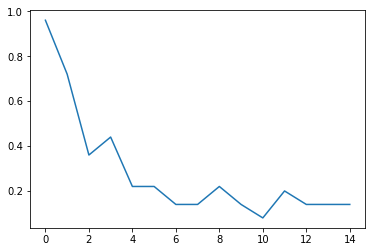

In [7]:
d = 784
number_classes = 10
x = tf.placeholder(tf.float32, shape=[None, d])
y_ = tf.placeholder(tf.float32, shape=[None, number_classes])
x_image = tf.reshape(x, [-1,28,28,1])

#layer 1
num_filters1 = 32
W_conv1 = weight_variable([5, 5, 1, num_filters1])
b_conv1 = bias_variable([num_filters1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# layer 2
W_conv2 = weight_variable([5, 5, num_filters1, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# FC layer 1
len_fc = 200
W_fc1 = weight_variable([7 * 7 * 64, len_fc])
b_fc1 = bias_variable([len_fc])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#keep_prob = tf.placeholder(tf.float32)
#h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## FC layer 2
W_fc2 = weight_variable([len_fc, 10])
b_fc2 = bias_variable([10])

#y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_graph = []

sess.run(tf.global_variables_initializer())
for i in range(300):
  batch = mnist.train.next_batch(50)


  if i%20 == 0:
    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})
    accuracy_graph.append(1.-train_accuracy)
    if i%100==0:
        print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})


print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels}))

plt.plot(accuracy_graph)

(array([ 13.,   6.,  28.,  10.,  28.,  41.,  21.,  58.,  24.,  49.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

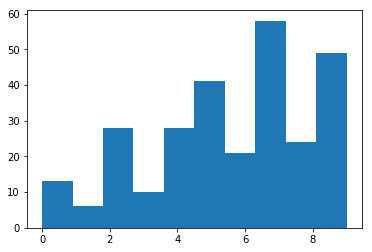

In [26]:
correct = correct_prediction.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
wrong = [not(b) for b in correct]
errors = mnist.test.images[wrong]
error_labels = tf.argmax(mnist.test.labels[wrong],1).eval()
plt.hist(error_labels)

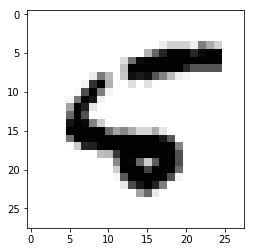

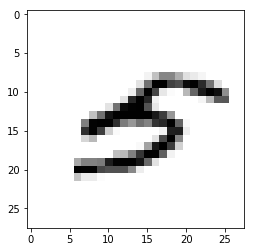

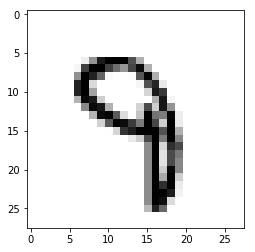

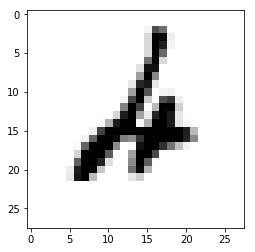

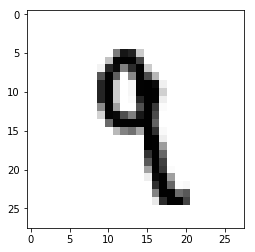

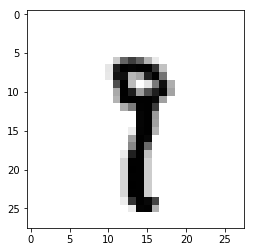

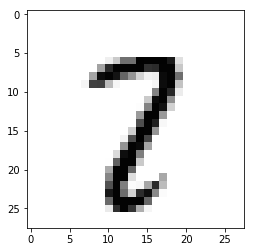

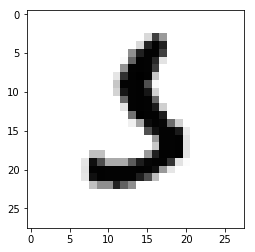

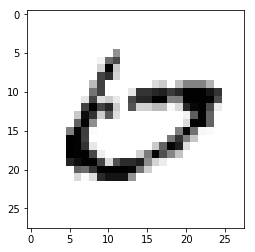

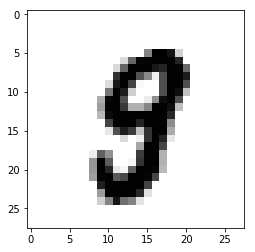

In [28]:
for im in errors[:10]:
    show_x(im)